In [1]:
from mmdet.apis import init_detector, inference_detector, show_result_pyplot
import mmcv
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt 

In [2]:
ls!

 Volume in drive C is Windows
 Volume Serial Number is B274-FED0

 Directory of C:\Users\skwe9\mmdetection



File Not Found


In [3]:
config_file = 'configs/mask_rcnn/mask_rcnn_r50_fpn_1x_coco.py'
# download the checkpoint from model zoo and put it in `checkpoints/`
# url: https://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_fpn_1x_coco/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth
checkpoint_file = 'laboro_tomato_big_48ep.pth'

In [4]:
# build the model from a config file and a checkpoint file
model = init_detector(config_file, checkpoint_file, device='cpu')

load checkpoint from local path: laboro_tomato_big_48ep.pth


In [5]:
# test a single image
img = 'image.png'
result = inference_detector(model, img)

C:\Users\skwe9\mmdetection\mmdet\datasets\utils.py:70: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  'data pipeline in your config file.', UserWarning)


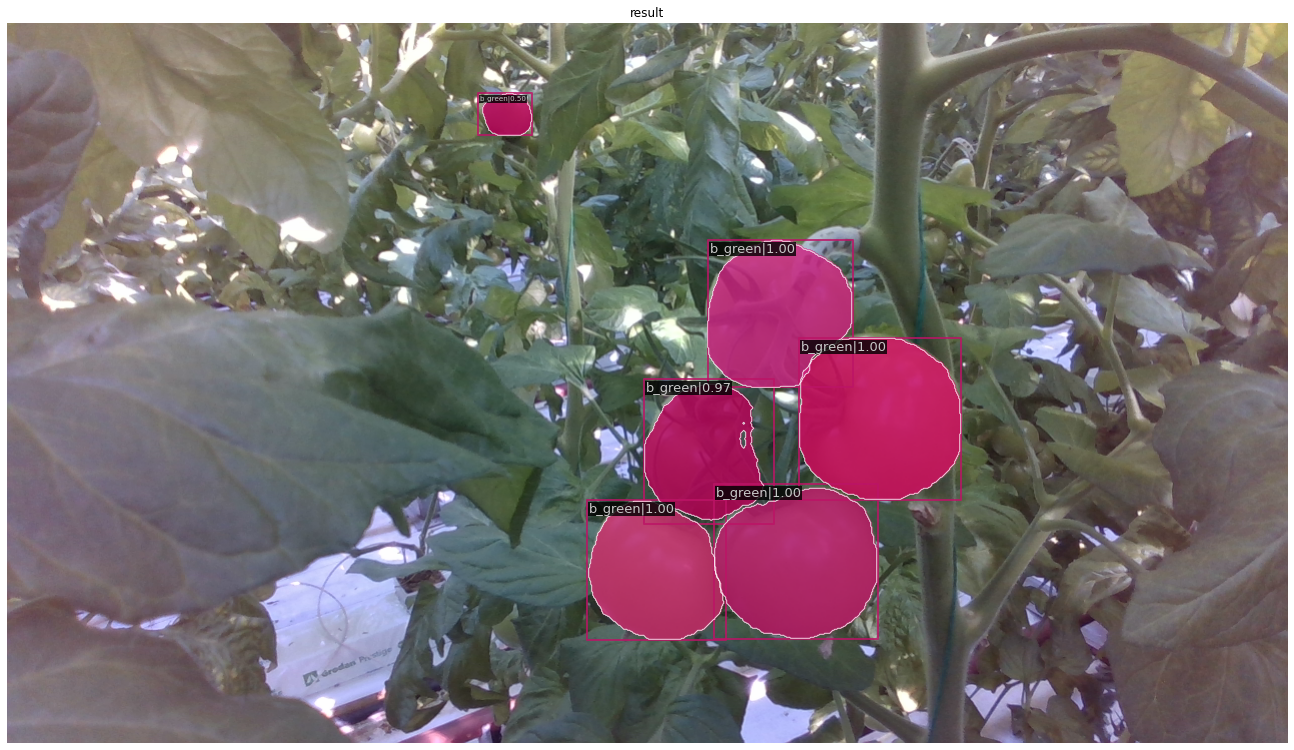

In [6]:
# show the results
show_result_pyplot(model, img, result)

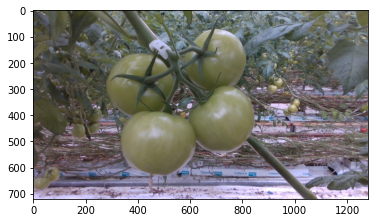

In [7]:
img = 'images/fecc62e5098940daa6d72020883ffc8d color.png'
image = plt.imread(img)
plt.imshow(image)

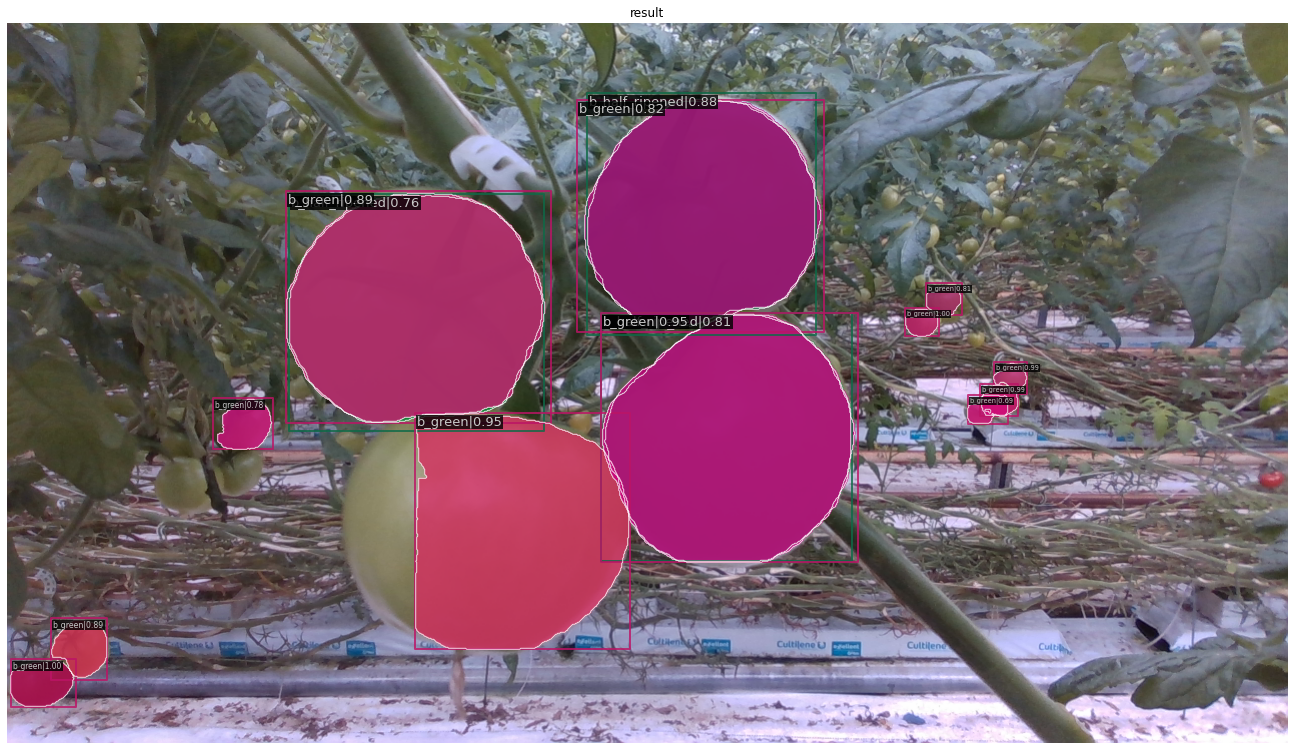

In [8]:
# test a single image
result = inference_detector(model, img)
# show the results
show_result_pyplot(model, img, result)

In [9]:
img = mmcv.imread('e609e3a4e47a459ca8487d5d49354eb5 color.png')
model = init_detector(config_file, checkpoint_file, device='cpu')
depthData = np.load('e609e3a4e47a459ca8487d5d49354eb5 depthData.npy')
result = inference_detector(model, img)

bbox_result, segm_result = result

labels = [
    np.full(bbox.shape[0], i, dtype=np.int32)\
    for i, bbox in enumerate(bbox_result)
]
labels = np.concatenate(labels)
bboxes = np.vstack(bbox_result)
segm_result = [x for x in segm_result if x != []]
segment = np.vstack(segm_result)
print(segment)

load checkpoint from local path: laboro_tomato_big_48ep.pth
[[[False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]
  ...
  [False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]]

 [[False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]
  ...
  [False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]]

 [[False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]
  ...
  [False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]]

 ...

 [[False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False

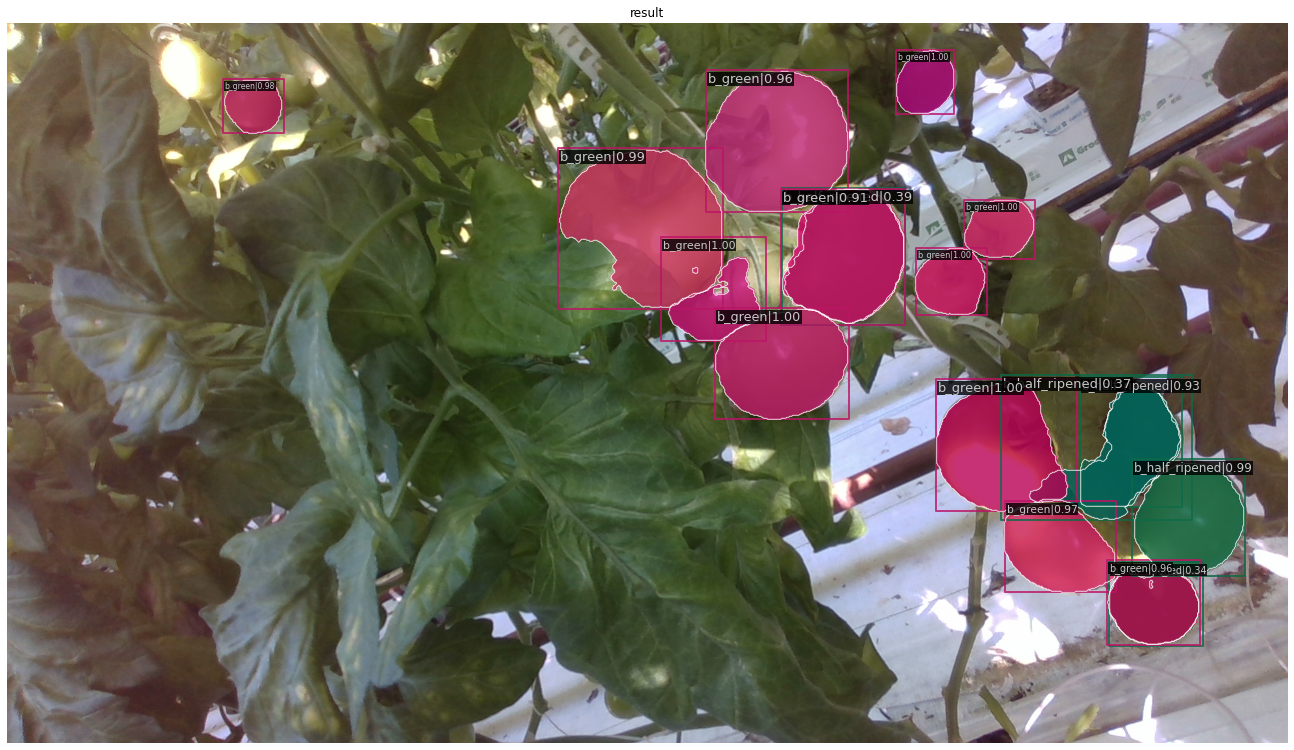

In [10]:
# show the results
show_result_pyplot(model, img, result)

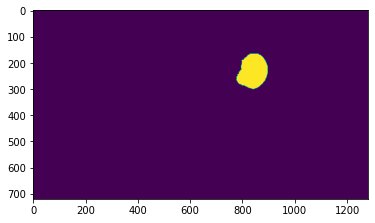

In [14]:
plt.imshow(segment[2])

In [15]:
from scipy.ndimage import convolve
mask = np.asarray(segment[2], dtype="uint8") #binary matrix
fil = [[-1,-1,-1],
       [-1, 8,-1],
       [-1,-1,-1]]

output = convolve(mask,fil, mode='constant')
print(output)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


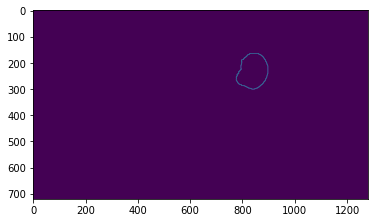

In [16]:
plt.imshow(output)

In [111]:
edgeDepth =[]
for y in range(len(output)):
        for x in range(len(output[y])):
                if output[y][x] > 0:
                    edgeDepth.append(depthData[y][x])
                    
from numpy import median
centerDepth = np.percentile(edgeDepth, 75)
#centerDepth = median(edgeDepth)
print(centerDepth)

0.527999997138977


In [112]:
import pyrealsense2 as rs

color_intrin = rs.pyrealsense2.intrinsics() #create a color intrinsics property
color_intrin.width = 1280
color_intrin.height = 720
color_intrin.ppx = 646.9525146484375
color_intrin.ppy = 375.3297119140625
color_intrin.fx = 911.9494018554688
color_intrin.fy = 912.0560302734375
color_intrin.model = rs.pyrealsense2.distortion.inverse_brown_conrady
color_intrin.coeffs = [0.0, 0.0, 0.0, 0.0, 0.0]

left = bboxes[6][0]
top = bboxes[6][1]
right = bboxes[6][2]
bottom = bboxes[6][3]
print(left)

centerX = int((left + right)/2)
centerY = int((top + bottom)/2)

print(centerX)
print(centerY)

centerPoint = rs.rs2_deproject_pixel_to_point(color_intrin, [centerX, centerY], centerDepth)
multiplied_center = [element*1000 for element in centerPoint]
print(multiplied_center)

996.0143
1051
523
[233.93520712852478, 85.48806607723236, 527.999997138977]


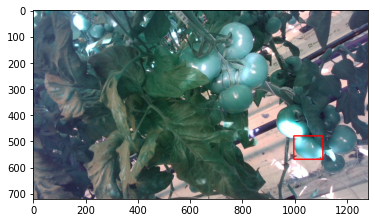

In [113]:
image = cv.rectangle(img, (int(left), int(top)), (int(right), int(bottom)), (255,0,0), 3)
plt.imshow(image)

In [114]:
pointCloud = []
for y in range(len(mask)):
    for x in range(len(mask[y])):
        if mask[y][x] == 1 and depthData[y][x] != None:
            coordinate = rs.rs2_deproject_pixel_to_point(color_intrin, [x, y], depthData[y][x])
            multiplied_list = [element*1000 for element in coordinate]
            pointCloud.append(multiplied_list)
np.savetxt('point_out.txt', pointCloud, delimiter=' ', fmt='%f')
np.save('file.npy', pointCloud)

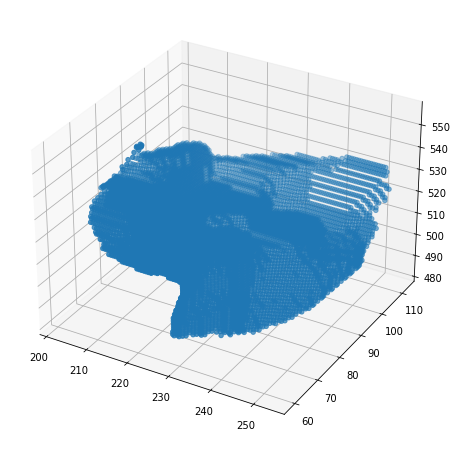

In [115]:
data = np.load('file.npy')
x = data[:, 0]
y = data[:, 1]
z = data[:, 2]

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import proj3d

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x, y, z)
plt.show()

In [116]:
import math
newPointCloud = []
# https://math.stackexchange.com/questions/83404/finding-a-point-along-a-line-in-three-dimensions-given-two-points
for coordinate in range(len(pointCloud)):
    vectorX = multiplied_center[0] - pointCloud[coordinate][0]
    vectorY = multiplied_center[1] - pointCloud[coordinate][1]
    vectorZ = multiplied_center[2] - pointCloud[coordinate][2]
    vectorArray = [vectorX, vectorY, vectorZ]
    norm = np.linalg.norm(vectorArray)
    normal_array = vectorArray/norm
    distance = math.sqrt((vectorX)**2 + (vectorY)**2 + (vectorZ)**2)
    newPointCloud.append(pointCloud[coordinate])
    newX = pointCloud[coordinate][0] + 2 * distance * normal_array[0]
    newY = pointCloud[coordinate][1] + 2 * distance * normal_array[1]
    newZ = pointCloud[coordinate][2] + 2 * distance * normal_array[2]
    newPointCloud.append([newX, newY, newZ])
np.savetxt('point_new_out.txt', newPointCloud, delimiter=' ', fmt='%f')
np.save('new_file.npy', newPointCloud)

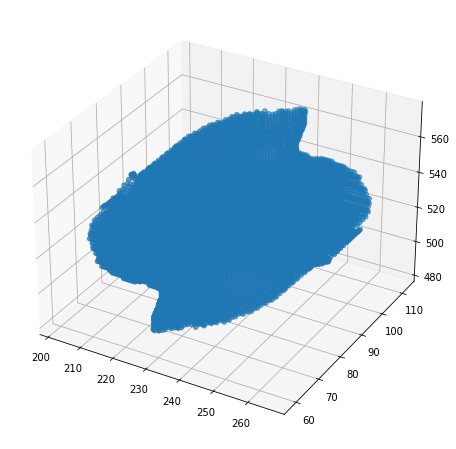

In [117]:
data = np.load('new_file.npy')
x = data[:, 0]
y = data[:, 1]
z = data[:, 2]

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import proj3d

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x, y, z)
plt.show()